# Google colab commands

In [1]:
!git clone https://github.com/Francesco9932/financial-sentiment-analysis

Cloning into 'financial-sentiment-analysis'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 62 (delta 9), reused 14 (delta 4), pack-reused 42
Unpacking objects: 100% (62/62), 112.00 MiB | 7.26 MiB/s, done.


In [2]:
%cd financial-sentiment-analysis/

/content/financial-sentiment-analysis


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-27 12:03:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-27 12:03:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-27 12:03:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [4]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00


# Import

In [6]:
from transformers import TFDistilBertModel
from transformers import DistilBertTokenizer
import pandas as pd
import numpy as np

# pre-processing
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import *
from nltk.corpus import stopwords
import re
import nltk 
nltk.download("stopwords")

from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data preprocessing

In [7]:
df = pd.read_csv('all-data.csv', encoding="latin-1",
                 names=['sentiment', 'headline'])
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


<Axes: >

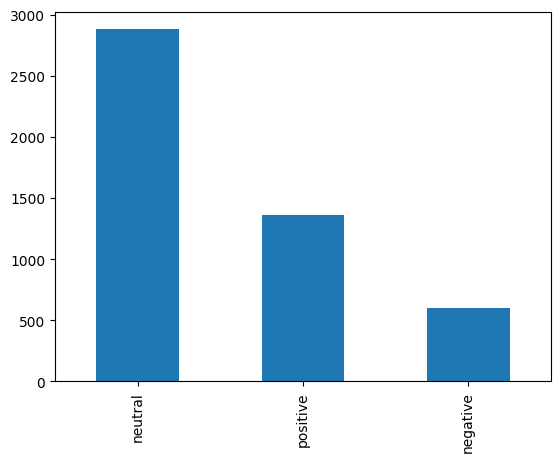

In [8]:
df['sentiment'].value_counts().plot(kind='bar')

In [9]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (4846, 2)
after drop duplicates shape:  (4840, 2)
after drop null shape:  (4840, 2)


In [10]:
df['headline'][1]

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [11]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]

    ## apply stemming
    # words = [PorterStemmer().stem(w) for w in words]
    ## return list

    return  ' '.join(map(str, words))

#print("\nOriginal headline ->", df['headline'][0])

#df['headline'] = df['headline'].apply(headline_to_words)

#print("\nProcessed headline ->", df['headline'][0])

# not used nltk preprocessing

In [12]:
sentences = df['headline'].to_list()

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])

<ipython-input-12-14f8b9103463>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = le.transform(df['sentiment'])


# Tokenizer for other models

In [13]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
print("Vocab length:", len(word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

Vocab length: 10123
Maximum sequence length: 71


In [14]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

In [15]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

Train Set -> (3388, 71) (3388,)
Test Set -> (1452, 71) (1452,)


# Global Vectors for Word Representation (GloVe)

In [16]:
vocab_size = 10123
embedding_size = 200

embeddings_index = {}

with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [17]:
print(embeddings_matrix.shape)

(10124, 200)


# CNN1d Model

In [18]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1],
                              weights=[embeddings_matrix])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)  
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 71, 200)      2024800     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 70, 200)      80200       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 69, 200)      120200      ['embedding[0][0]']              
                                                                                              

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6451
Epoch 1: val_accuracy improved from -inf to 0.68142, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 42s 258ms/step - loss: 0.8599 - accuracy: 0.6451 - val_loss: 0.7082 - val_accuracy: 0.6814
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7947
Epoch 2: val_accuracy improved from 0.68142 to 0.74926, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 8s 80ms/step - loss: 0.5089 - accuracy: 0.7947 - val_loss: 0.5886 - val_accuracy: 0.7493
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9032
Epoch 3: val_accuracy did not improve from 0.74926
96/96 [==============================] - 4s 45ms/step - loss: 0.2587 - accuracy: 0.9032 - val_loss: 0.7088 - val_accuracy: 0.7463
Epoch 4/100
96/96 [==============================] - ETA: 0s - lo

In [20]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 0.86719
Test accuracy: 79.68320%


# LSTM Model

In [21]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.6435
Epoch 1: val_accuracy improved from -inf to 0.69027, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 19s 159ms/step - loss: 0.8228 - accuracy: 0.6435 - val_loss: 0.7227 - val_accuracy: 0.6903
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8462
Epoch 2: val_accuracy improved from 0.69027 to 0.71091, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 10s 109ms/step - loss: 0.4120 - accuracy: 0.8462 - val_loss: 0.6476 - val_accuracy: 0.7109
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9600
Epoch 3: val_accuracy did not improve from 0.71091
96/96 [==============================] - 5s 49ms/step - loss: 0.1325 - accuracy: 0.9600 - val_loss: 1.1374 - val_accuracy: 0.6991
Epoch 4/100
96/96 [==============================] - ETA: 0s - lo

In [23]:
saved_model = load_model('./best_model/best_model_lstm.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

Test Losss: 1.94224
Test accuracy: 74.17355%


# BERT Finetune

In [ ]:
finBertTokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
finBert = TFBertModel.from_pretrained('ProsusAI/finbert')

distilBertTokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilBert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
def create_BERT_wrapper(bert_embeddings, max_len):
    input_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="attention_mask")

    embeddings = finBert(input_ids, attention_mask=input_mask)[
        0]  # 0 = last hidden state, 1 = poller_output

    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = tf.keras.layers.Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.1)(out)
    out = tf.keras.layers.Dense(32, activation='relu')(out)

    y = tf.keras.layers.Dense(3, activation='softmax')(out)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

    model.layers[2].trainable = True
    # check https://stackoverflow.com/questions/60463829/training-tfbertforsequenceclassification-with-custom-x-and-y-data

    return model


In [25]:
def calculate_max_sentence_len(sentences, tokenizer):
    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

In [26]:
def train_test_set(tokenizer):
    train_sentences, test_sentences, labels_train, labels_test = train_test_split(
    sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)
    
    max_len = min(calculate_max_sentence_len(train_sentences, tokenizer),
              calculate_max_sentence_len(test_sentences, tokenizer))
    
    print('Max sentence length: ', max_len)
    
    X_train = tokenizer(
    text=train_sentences,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

    X_test = tokenizer(
    text=test_sentences,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
    )
    print("\nTrain split shape: ", X_train['input_ids'].shape) # the same for attention mask
    print("\nTest split shape: ", X_test['input_ids'].shape)

    return X_train, X_test, labels_train, labels_test, max_len

In [27]:
X_train, X_test, labels_train, labels_test, max_len_finBert = train_test_set(finBertTokenizer)


Max sentence length:  93

Train split shape:  (3388, 93)

Test split shape:  (1452, 93)


# finBERT

In [28]:
model = create_BERT_wrapper(finBert, max_len_finBert)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 93)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 93)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 93,                                          

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model/finetuned_finbert.h5',
                     monitor='val_balanced_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - ETA: 0s - loss: 0.4294 - balanced_accuracy: 0.8239
Epoch 1: val_balanced_accuracy improved from -inf to 0.87316, saving model to ./best_model/finetuned_finbert.h5
96/96 [==============================] - 136s 856ms/step - loss: 0.4294 - balanced_accuracy: 0.8239 - val_loss: 0.3156 - val_balanced_accuracy: 0.8732
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.2025 - balanced_accuracy: 0.9239
Epoch 2: val_balanced_accuracy did not improve from 0.87316
96/96 [==============================] - 65s 675ms/step - loss: 0.2025 - balanced_accuracy: 0.9239 - val_loss: 0.4535 - val_balanced_accuracy: 0.8230
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.0892 - balanced_accuracy: 0.9675
Epoch 3: val_balanced_accuracy did not improve from 0.87316
96/96 [==============================] - 62s 650ms/step - loss: 0.0892 - balanced_accuracy: 0.9675 - val_loss: 0.4379 - val_balanced_accuracy: 0.8584
Epoch 4/10
96/96 [=

In [30]:
saved_model = load_model('./best_model/finetuned_finbert.h5', custom_objects={"TFBertModel": TFBertModel})

# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted))

46/46 [==============================] - 12s 203ms/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       183
           1       0.88      0.93      0.91       839
           2       0.86      0.77      0.81       430

    accuracy                           0.87      1452
   macro avg       0.87      0.86      0.86      1452
weighted avg       0.87      0.87      0.87      1452



# distilBERT

In [31]:
X_train, X_test, labels_train, labels_test, max_len_distilBert = train_test_set(distilBertTokenizer)

Max sentence length:  93

Train split shape:  (3388, 93)

Test split shape:  (1452, 93)


In [32]:
model = create_BERT_wrapper(distilBert, max_len_distilBert)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 93)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 93)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 93, 768),                                                    
                                 hidden_states=None                                         

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model/finetuned_distilbert.h5',
                     monitor='val_balanced_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - ETA: 0s - loss: 0.6435 - balanced_accuracy: 0.7202
Epoch 1: val_balanced_accuracy improved from -inf to 0.80236, saving model to ./best_model/finetuned_distilbert.h5
96/96 [==============================] - 67s 422ms/step - loss: 0.6435 - balanced_accuracy: 0.7202 - val_loss: 0.4244 - val_balanced_accuracy: 0.8024
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.2887 - balanced_accuracy: 0.8872
Epoch 2: val_balanced_accuracy improved from 0.80236 to 0.84956, saving model to ./best_model/finetuned_distilbert.h5
96/96 [==============================] - 36s 374ms/step - loss: 0.2887 - balanced_accuracy: 0.8872 - val_loss: 0.3799 - val_balanced_accuracy: 0.8496
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.1327 - balanced_accuracy: 0.9515
Epoch 3: val_balanced_accuracy did not improve from 0.84956
96/96 [==============================] - 33s 340ms/step - loss: 0.1327 - balanced_accuracy: 0.9515 - val_loss

In [34]:
saved_model = load_model('./best_model/finetuned_distilbert.h5',
                         custom_objects={"TFDistilBertModel": TFDistilBertModel})

# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted))

46/46 [==============================] - 6s 105ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       183
           1       0.88      0.88      0.88       839
           2       0.79      0.79      0.79       430

    accuracy                           0.85      1452
   macro avg       0.83      0.83      0.83      1452
weighted avg       0.85      0.85      0.85      1452

